## STERNUM

In [1]:
import pandas as pd
import numpy as np

from scipy import signal
import scipy.linalg as la
from scipy.stats import norm
from scipy.integrate import trapz
import math as m
import pywt

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
from matplotlib.gridspec import GridSpec

## Load the orginal data

In [2]:
# original dataset
DF = pd.read_csv('center_sternum.txt',sep='\t')  
DF

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031
1,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806
2,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827
3,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383
4,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,5,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126,0.650810,0.379162,-0.636402,0.166356
16502,5,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125,0.650239,0.379803,-0.636708,0.165960
16503,5,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125,0.649365,0.380627,-0.637227,0.165502
16504,5,200,1576222847,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124,0.648973,0.381329,-0.637348,0.164953


## Select only the meaningful data

Al fine di selezionare un intervallo significativo dei dati raccolti, è stato eseguito un plot rappresentativo di AccX GyroX MagnX in funzione del tempo. Il tempo (in secondi) associato a ciascuna misura è stato derivato dalla frequenza di campionamento 'Log Freq'=200Hz.

Come intervallo signficativo si è, dunque, tenuto quello compreso tra [7.5,70] s, come mostrato in figura. A questo punto il tempo è stato riscalato, in modo che la prima misurazione significativa corrisponda a 0s.

Text(0, 0.5, 'Magnetic Field [mG]')

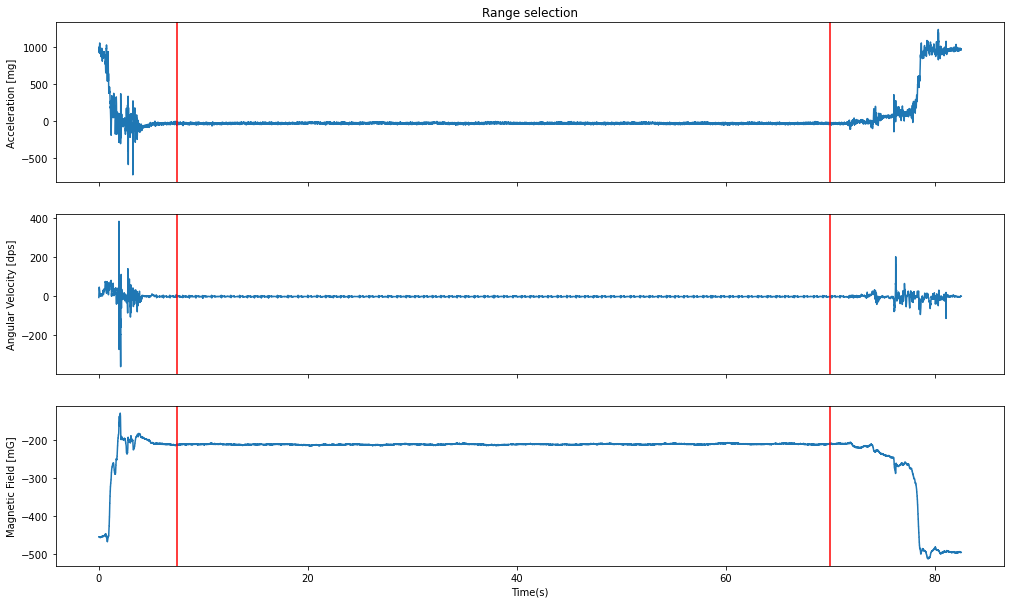

In [3]:
# plot raw data
(fig, (ax1,ax2,ax3)) = plt.subplots(3,1,figsize=(17,10), sharex=True)

t = np.arange(0, len(DF['AccX']))/DF['Log Freq'][0]
ax1.plot(t, DF['AccX'])
ax1.axvline(x = 7.5, color = 'red')
ax1.axvline(x = 70, color = 'red')
ax1.set_ylabel('Acceleration [mg]')
ax1.set_title('Range selection')

ax2.plot(t, DF['GyroX'])
ax2.axvline(x = 7.5, color = 'red')
ax2.axvline(x = 70, color = 'red')
ax2.set_ylabel('Angular Velocity [dps]')

ax3.plot(t, DF['MagnX'])
ax3.axvline(x = 7.5, color = 'red')
ax3.axvline(x = 70, color = 'red')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Magnetic Field [mG]') 


Le colonne di maggior interesse sono quelle contenenti le misurazioni fatte da Accelerometro(mg), Giroscopio(dps), Magnetometro(mG) e relativi tempi(s). I dati relativi ai quaternioni sono stati scartati in quanto il segnale ha una qualità peggiore e l'informazione che portano è ridondante ai fini dell'analisi.

In [4]:
# new dataset with only the interesting data
a = 1500
b = 14000
freq = DF['Log Freq'][0]
df = DF.iloc[a:b+1]    
df = df.drop(['Log Mode', 'Log Freq', 'Timestamp','qw', 'qi', 'qj', 'qk'], axis=1) 
df['Time'] = np.arange(0, len(df['AccX']))/freq
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
1500,-24.949,115.046,-951.661,0.687023,4.870229,1.511450,-212,-434,435,0.000
1501,-10.980,106.323,-971.059,1.358779,3.358779,1.099237,-212,-435,435,0.005
1502,-17.690,109.800,-970.022,1.068702,3.160305,0.702290,-213,-435,434,0.010
1503,-21.533,104.249,-965.630,0.687023,2.793893,0.381679,-213,-435,434,0.015
1504,-23.668,104.737,-967.033,0.305343,2.748092,0.778626,-214,-435,435,0.020
...,...,...,...,...,...,...,...,...,...,...
13996,-30.866,118.767,-941.108,-3.175573,3.358779,-0.778626,-210,-430,427,62.480
13997,-32.818,118.279,-942.145,-2.992366,3.679389,-0.549618,-210,-430,427,62.485
13998,-22.692,113.704,-948.184,-3.022901,3.786260,-0.564885,-211,-432,427,62.490
13999,-38.674,119.743,-937.143,-2.854962,3.419847,-0.885496,-211,-432,427,62.495


## Calibration

Di seguito è riportata la procedura di calibrazione eseguita sul dataset.

In [5]:
# calibration matrices and offset vectors
gyro_off = np.array([-2.242224,2.963463,-0.718397])
acc_cal = np.array([[1.000966,-0.002326418,-0.0006995499],
                    [-0.002326379,0.9787045,-0.001540918],
                    [-0.0006995811,-0.001540928,1.00403]])
acc_off = np.array([-3.929942,-13.74679,60.67546])
magn_cal=np.array([[0.9192851,-0.02325168,0.003480837],
                   [-0.02325175,0.914876,0.004257396],
                   [0.003481006,0.004257583,0.8748001]])
magn_off=np.array([-95.67974,-244.9142,17.71132])

In [6]:
# calibration procedure
df[['GyroX','GyroY','GyroZ']] = df[['GyroX','GyroY','GyroZ']] + gyro_off.T
df[['AccX','AccY','AccZ']] = np.dot(df[['AccX','AccY','AccZ']],acc_cal.T) + acc_off.T
df[['MagnX','MagnY','MagnZ']] = np.dot(df[['MagnX','MagnY','MagnZ']],magn_cal.T) + magn_off.T
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
1500,-28.504953,100.373720,-894.980558,-1.555201,7.833692,0.793053,-278.962788,-635.189046,395.663599,0.000
1501,-14.488596,91.833874,-914.453062,-0.883445,6.322242,0.380840,-278.939536,-636.103922,395.659342,0.005
1502,-21.213892,95.250842,-913.412547,-1.173522,6.123768,-0.016107,-279.862302,-636.084927,394.781061,0.010
1503,-25.050763,89.820226,-908.991605,-1.555201,5.757356,-0.336718,-279.862302,-636.084927,394.781061,0.015
1504,-27.187979,90.304963,-910.399517,-1.936881,5.711555,0.060229,-280.778107,-636.057418,395.652380,0.020
...,...,...,...,...,...,...,...,...,...,...
13996,-34.443708,104.012984,-884.386623,-5.417797,6.322242,-1.497023,-277.245071,-631.610104,388.689191,62.480
13997,-36.395733,103.541515,-885.425685,-5.234590,6.642852,-1.268015,-277.245071,-631.610104,388.689191,62.485
13998,-26.245083,99.049690,-891.489056,-5.265125,6.749723,-1.283282,-278.117853,-633.416605,388.677195,62.490
13999,-42.264295,104.980254,-880.401686,-5.097186,6.383310,-1.603893,-278.117853,-633.416605,388.677195,62.495


## Statistical analysis:

Mean, median, variance, standard deviation, 25th and 75th percentiles:

In [7]:
# statistical descriptors
stat_df = pd.DataFrame({
    'mean'  : df.mean(),
    'median': df.median(),
    'variance': df.var(),
    'standard deviation': df.std(),
    '25% percentile' : df.quantile(q=0.25),
    '75% percentile': df.quantile(q=0.75)
    }).T
stat_df.drop(['Time'], axis=1)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
mean,-34.309794,100.734210,-892.685252,-4.328721,6.644769,-1.585265,-278.662436,-633.718653,391.202763
median,-34.260318,100.958415,-893.069606,-4.394896,6.597051,-1.573359,-278.962788,-633.416605,391.286894
variance,49.866401,29.206212,212.532768,2.080482,0.532462,0.145359,1.437342,3.149817,6.780515
standard deviation,7.061615,5.404277,14.578504,1.442388,0.729700,0.381260,1.198892,1.774772,2.603942
25% percentile,-38.950034,97.321571,-901.411472,-4.944514,6.230639,-1.832901,-279.099931,-635.184788,388.689191
75% percentile,-29.601040,104.292364,-884.704283,-3.707873,6.963463,-1.344351,-278.046984,-632.478477,393.907037


La media serve al centramento dei dati. La varianza indica quale componente ha la maggior varibilità (vedi PCA dopo). Eventuali commenti sul posizionamento del sensore.

Correlation coefficients:

In [8]:
# corr.coeff.
M = df.loc[:,:'MagnZ'].corr()  
M

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
AccX,1.000000,-0.175850,-0.406324,0.211097,0.006664,0.027037,-0.380642,-0.022166,0.071081
AccY,-0.175850,1.000000,0.173606,-0.049653,0.000488,-0.103754,0.233688,0.353350,-0.491820
AccZ,-0.406324,0.173606,1.000000,-0.079548,0.117838,0.019098,0.119201,0.202044,-0.247645
GyroX,0.211097,-0.049653,-0.079548,1.000000,0.400553,0.368676,-0.061395,-0.057079,0.024329
GyroY,0.006664,0.000488,0.117838,0.400553,1.000000,0.426017,0.012710,-0.129760,0.021824
GyroZ,0.027037,-0.103754,0.019098,0.368676,0.426017,1.000000,-0.011409,-0.072499,0.012388
MagnX,-0.380642,0.233688,0.119201,-0.061395,0.012710,-0.011409,1.000000,0.216823,-0.307836
MagnY,-0.022166,0.353350,0.202044,-0.057079,-0.129760,-0.072499,0.216823,1.000000,-0.744287
MagnZ,0.071081,-0.491820,-0.247645,0.024329,0.021824,0.012388,-0.307836,-0.744287,1.000000


I coefficienti di correlazioni non sono molto alti, probabilmente a causa dell'intensità del segnale che non è elevata rispetto al rumore.

## Centering the data


In [9]:
# centered dataset
dfc = df - stat_df.iloc[0]
dfc['Time'] = df['Time']
dfc

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
1500,5.804840,-0.360490,-2.295306,2.773520,1.188923,2.378318,-0.300352,-1.470393,4.460836,0.000
1501,19.821197,-8.900336,-21.767811,3.445276,-0.322527,1.966105,-0.277100,-2.385269,4.456578,0.005
1502,13.095901,-5.483368,-20.727295,3.155199,-0.521001,1.569158,-1.199866,-2.366275,3.578297,0.010
1503,9.259030,-10.913984,-16.306353,2.773520,-0.887413,1.248547,-1.199866,-2.366275,3.578297,0.015
1504,7.121814,-10.429248,-17.714266,2.391840,-0.933214,1.645494,-2.115670,-2.338766,4.449616,0.020
...,...,...,...,...,...,...,...,...,...,...
13996,-0.133915,3.278773,8.298629,-1.089076,-0.322527,0.088242,1.417365,2.108548,-2.513572,62.480
13997,-2.085940,2.807305,7.259567,-0.905869,-0.001917,0.317250,1.417365,2.108548,-2.513572,62.485
13998,8.064710,-1.684520,1.196196,-0.936404,0.104954,0.301983,0.544584,0.302048,-2.525569,62.490
13999,-7.954502,4.246044,12.283566,-0.768465,-0.261459,-0.018628,0.544584,0.302048,-2.525569,62.495


## PCA

Dal momento che le misurazioni di accelerometro,giroscopio,magnetometro sono state fatte lungo i tre assi, si è applicata l'analisi PCA per stabilire quale di queste componenti portasse l'informazione maggiore.

In [10]:
N = dfc.shape[0]

#Acc
U_acc,D_diag_acc,_=la.svd(dfc[['AccX','AccY','AccZ']].T)
avl_acc = np.real_if_close(D_diag_acc)**2/(N-1)
avl_acc_n = avl_acc/avl_acc.sum()

#Gyro
U_gyro,D_diag_gyro,_=la.svd(dfc[['GyroX','GyroY','GyroZ']].T)
avl_gyro = np.real_if_close(D_diag_gyro)**2/(N-1)
avl_gyro_n = avl_gyro/avl_gyro.sum()

#Magn
U_magn,D_diag_magn,_=la.svd(dfc[['MagnX','MagnY','MagnZ']].T)
avl_magn = np.real_if_close(D_diag_magn)**2/(N-1)
avl_magn_n = avl_magn/avl_magn.sum()

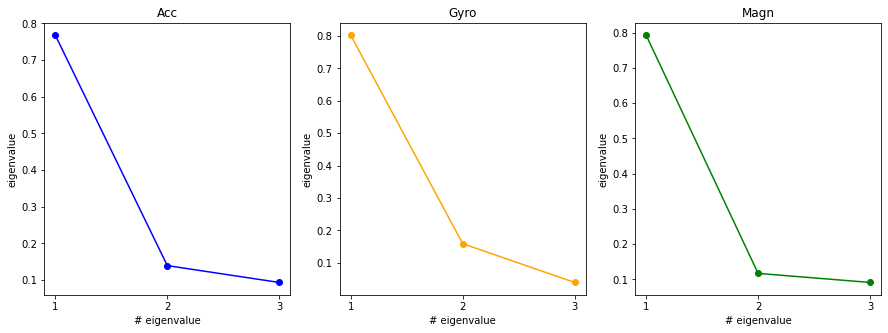

In [11]:
#Plot
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax1.plot(np.arange(U_acc.shape[0])+1, avl_acc_n, color = 'blue', marker = 'o')
ax1.set_title('Acc')
ax1.set_xlabel('# eigenvalue')
ax1.set_ylabel('eigenvalue')
ax1.xaxis.set_major_locator(MultipleLocator(1.000))
ax2.plot(np.arange(U_gyro.shape[0])+1, avl_gyro_n, color = 'orange', marker = 'o')
ax2.set_title('Gyro')
ax2.set_xlabel('# eigenvalue')
ax2.set_ylabel('eigenvalue')
ax2.xaxis.set_major_locator(MultipleLocator(1.000))
ax3.plot(np.arange(U_magn.shape[0])+1, avl_magn_n, color = 'green', marker = 'o')
ax3.set_title('Magn')
ax3.set_xlabel('# eigenvalue')
ax3.set_ylabel('eigenvalue')
ax3.xaxis.set_major_locator(MultipleLocator(1.000))
plt.show()

In [12]:
#print('eigenvalues and eigenvectors (Acc): \n', a, '\n\n',b, '\n')
#print('eigenvalues and eigenvectors (Gyro): \n', c, '\n\n',d, '\n')
#print('eigenvalues and eigenvectors (Magn): \n', e, '\n\n',f, '\n')

(stampare autovalori?)

Dalla PCA si evince che per l'accelerometro la prima componente principale sia la Z, gyro x, magn z e ritorna col posizionamento del sensore con asse z uscente dal petto, x punta alla testa e y dx sx.

Le prima componente principale comprende l'80% di variabilità, quindi d'ora in poi nell'analisi terremo conto solo di essa.

I dati sono stati ruotati nel nuovo sistema di riferimento:

In [13]:
# rotated dataset after PCA
rot = np.dot(dfc[['AccX','AccY','AccZ']],U_acc)
rot1 = np.dot(dfc[['GyroX','GyroY','GyroZ']],U_gyro)
rot2 = np.dot(dfc[['MagnX','MagnY','MagnZ']],U_magn)
dfr = pd.DataFrame({'Acc1': rot[:,0], 'Acc2': rot[:,1],'Acc3': rot[:,2],
                    'Gyro1': rot1[:,0], 'Gyro2': rot1[:,1],'Gyro3': rot1[:,2],
                    'Magn1': rot2[:,0], 'Magn2': rot2[:,1],'Magn3': rot2[:,2]})

dfr['Time'] = dfc['Time'].values
dfr


,Acc1,Acc2,Acc3,Gyro1,Gyro2,Gyro3,Magn1,Magn2,Magn3,Time
0,-3.620661,-4.951137,-1.213096,-3.223768,-0.851720,1.908990,4.578555,-0.067279,1.087950,0.000
1,-26.443051,-15.398988,3.093484,-3.448854,0.834583,1.802331,5.038141,0.304745,0.389426,0.005
2,-23.587832,-8.501977,1.587854,-3.077112,1.022839,1.474503,4.411004,-0.482168,-0.392049,0.010
3,-18.813683,-7.384770,7.890016,-2.583671,1.330052,1.262692,4.411004,-0.482168,-0.392049,0.015
4,-19.636443,-4.914679,7.971240,-2.248087,1.193202,1.679825,5.263942,-1.404706,-0.250373,0.020
...,...,...,...,...,...,...,...,...,...,...
12496,8.321046,-1.099466,-3.030988,1.118839,-0.003412,0.214672,-3.405889,0.696579,0.829244,62.480
12497,7.739033,0.863841,-2.072332,0.837763,-0.302238,0.357848,-3.405889,0.696579,0.829244,62.485
12498,-0.872291,-8.264608,-0.493359,0.842180,-0.408187,0.321212,-2.373816,0.585901,-0.887704,62.490
12499,14.100415,5.471909,-1.850801,0.806698,0.045518,0.080076,-2.373816,0.585901,-0.887704,62.495


Text(0.5, 0, 'Time(s)')

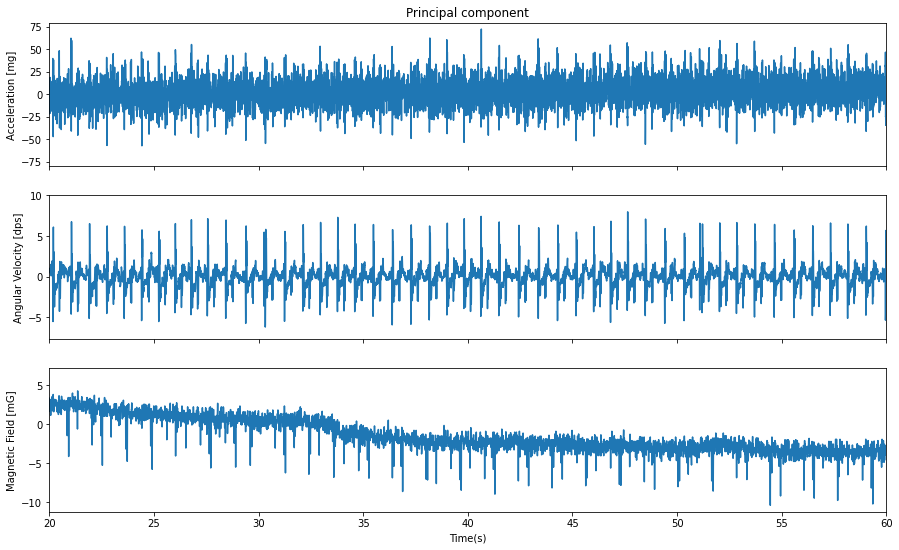

In [14]:
# principal component plots
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(15,9),sharex=True)
ax[0].plot(dfr['Time'],dfr['Acc1'])
ax[0].set_ylabel('Acceleration [mg]')
ax[0].set_title('Principal component')
ax[1].plot(dfr['Time'],dfr['Gyro1'])
ax[1].set_ylabel('Angular Velocity [dps]')
ax[2].plot(dfr['Time'],dfr['Magn1'])
ax[2].set_ylabel('Magnetic Field [mG]')

ax[2].set_xlim(20,60)
ax[2].set_xlabel('Time(s)')


## FFT analysis

Per ciascuna componente principale è stata calcolata la FFT per evidenziare la frequenza cardiaca nello spettro, tra 40BPM e 100BPM.

heart beat freq acc = 1.152 +/- 0.009 
heart beat freq gyro = 1.152 +/- 0.009 


Text(0, 0.5, 'Amplitude')

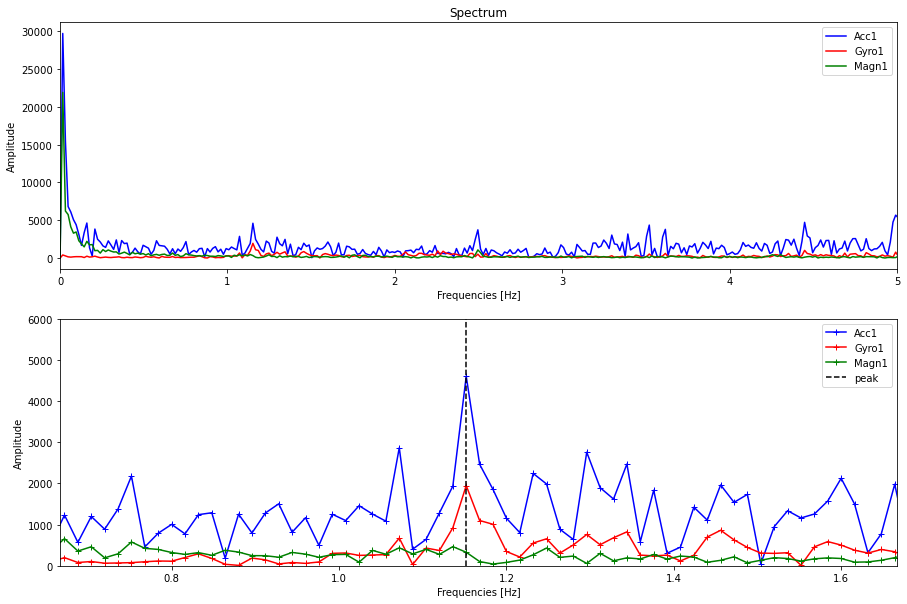

In [15]:
# HeartBeat freq
min_f=40./60.
max_f=100./60.

# FFT
A1_FFT = np.abs(np.fft.rfft(dfr['Acc1']))
G1_FFT = np.abs(np.fft.rfft(dfr['Gyro1']))
M1_FFT = np.abs(np.fft.rfft(dfr['Magn1']))
freq_FFT = np.fft.rfftfreq(d=1/freq, n=len(dfr['Acc1']))

X = []
YA = []
YG = []
for i in range(len(A1_FFT)):
    if freq_FFT[i]<=max_f and freq_FFT[i]>=min_f:
        X.append(freq_FFT[i])
        YA.append(A1_FFT[i])
        YG.append(G1_FFT[i])
        
peakA,_ = signal.find_peaks(YA, height=4000)
peakG,_ = signal.find_peaks(YG, height=1500)

print('heart beat freq acc = %.3f +/- %.3f ' % (X[peakA[0]] ,0.009))
print('heart beat freq gyro = %.3f +/- %.3f ' % (X[peakG[0]] ,0.009))

# spectrum
fig, (ax1,ax2) = plt.subplots(2,1,figsize = (15,10))
ax1.plot(freq_FFT, A1_FFT,'b-', label='Acc1')
ax1.plot(freq_FFT, G1_FFT,'r-', label='Gyro1')
ax1.plot(freq_FFT, M1_FFT,'g-', label='Magn1')
ax1.set_xlim(0,5)
ax1.legend(loc='best')
ax1.set_xlabel('Frequencies [Hz]')
ax1.set_title('Spectrum')
ax1.set_ylabel('Amplitude')

ax2.plot(freq_FFT, A1_FFT,'b-+', label='Acc1')
ax2.plot(freq_FFT, G1_FFT,'r-+', label='Gyro1')
ax2.plot(freq_FFT, M1_FFT,'g-+', label='Magn1')
plt.axvline(x = X[peakG[0]], color='k', linestyle='dashed', label='peak')
ax2.set_xlim(min_f, max_f)
ax2.set_ylim(0,6000)
ax2.legend(loc='best')
ax2.set_xlabel('Frequencies [Hz]')
ax2.set_ylabel('Amplitude')

Selezionando le frequenze tra 40BPM e 100BPM si nota che il magn non presenta frequenze dominanti quindi lo scartiamo da qui in poi. Mentre nello spettro di Acc e Gyro si distingue chiaramente un picco riconducibile al battito cardiaco coincidente per entrambi i dataset, a $1.152 \pm 0.009$ Hz , che corrisponde ad un BPM di 69.


## SIGNAL FILTERING

Per ottenere una miglior stima del BPM si è proceduto con l'analisi e la pulizia dei segnali attraverso:

- Wavelet transform
- Hilbert envelop
- Bandpass filter (40-200)BPM (?)


citare articolo

In [16]:
sigA = dfr['Acc1']
sigG = dfr['Gyro1']
t = dfr['Time']

Riguardo alle wavelet: l'ampiezza di un picco di battito è di circa 0.05s che equivale a 20Hz, per questo motivo nell'analisi delle Wavelet ci siamo fermati all'ordine 3, in modo da tenere i due coefficienti dettagliati che coprono le frequenze da 12.5Hz a 50 Hz.

In [17]:
# wavelet
def wavelet_decomposition(t, signal, n, color):
    coeff = pywt.wavedec(signal, 'bior5.5', level = n)
    sigs = np.zeros((n+1,len(t)+1))
    for i in range(n+1):
        ca = coeff.copy()
        for j in range(n+1):
            if j != i: 
                ca[j] = np.zeros_like(ca[j])
        sigs[i] = pywt.waverec(ca, 'bior5.5')
    ax = []
    fig, ax = plt.subplots(nrows = n+1, ncols = 1, figsize = (15, 5), sharex=True)
    ax[n].set_xlabel('Time [s]')
    for i in range(n+1):
        ax[i].plot(t, sigs[i][:-1], color = color)
    return coeff

In [18]:
# bandpass filter
def FILTER(SIG,f1,f2):
    FFT = np.fft.rfft(SIG)
    freq = np.fft.rfftfreq(len(SIG), 1/200)
    filt = np.zeros_like(freq)
    filt[(freq>f1) & (freq<f2)] = 1
    for i in range(len(freq)):
        if freq[i] > f1:
            filt[i-1] = 2/3
            filt[i-2] = 1/3
            break
    for i in range(len(freq)):
        if freq[i] > f2:
            filt[i] = 2/3
            filt[i+1] = 1/3
            break
    new_FFT = FFT*filt
    new_SIG = np.fft.irfft(new_FFT, len(SIG))
    return new_SIG


## Gyroscope

[array([-7.99103875, -7.74199591, -7.88814595, ...,  2.48421852,
         2.58929752,  2.39289586]),
 array([-0.1289026 , -1.43764645,  0.60013   , ..., -0.03486997,
        -0.26783798,  0.34288329]),
 array([-0.30290809, -0.39714509,  0.3733703 , ...,  0.14025908,
         0.16521763, -0.09060578]),
 array([ 0.09539094, -0.25734657,  0.18879631, ..., -0.06731432,
        -0.14192163,  0.07397298])]

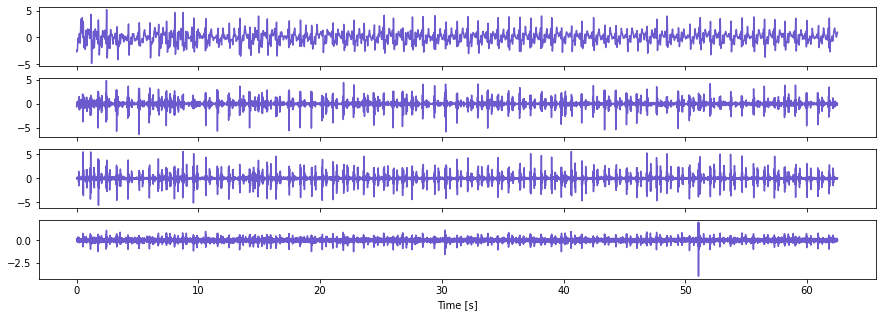

In [19]:
n=3
CG = wavelet_decomposition(t, sigG, n, 'slateblue')
CG

Text(0.5, 1.0, 'Wavelet Filtered Signal')

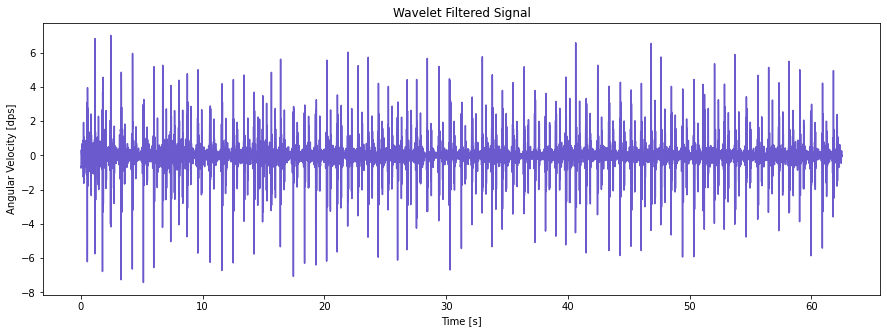

In [20]:
# filtered signal after wavelet decomposition
cg = CG.copy()
for j in range(n+1):
    if (j!=1) & (j!=2): 
        cg[j] = np.zeros_like(cg[j])
sigG_w = pywt.waverec(cg, 'bior5.5')
SIGG = sigG_w[:-1]

plt.figure(figsize=(15,5))
plt.plot(t, SIGG, color = 'slateblue')
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity [dps]')
plt.title('Wavelet Filtered Signal')

Text(0.5, 0, 'Time [s]')

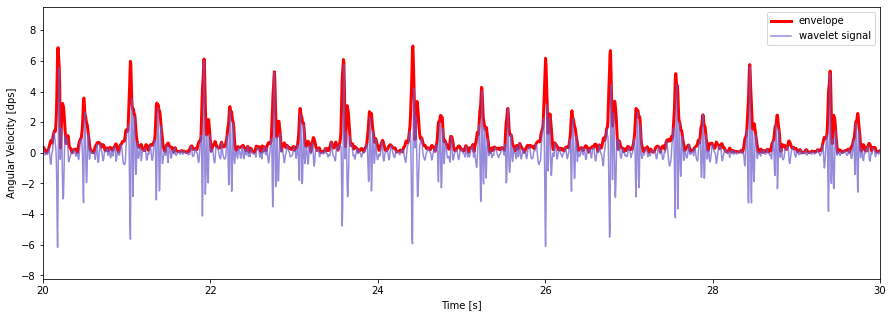

In [21]:
# envelope
SIGG_h = np.abs(signal.hilbert(SIGG))

plt.figure(figsize=(15,5))
plt.plot(t, SIGG_h, color = 'r', linewidth=3, label='envelope')
plt.plot(t, SIGG, 'slateblue', alpha=0.7, label='wavelet signal')
plt.legend(loc='best')
plt.xlim(20, 30)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')

Text(0.5, 1.0, 'Filtered Signal')

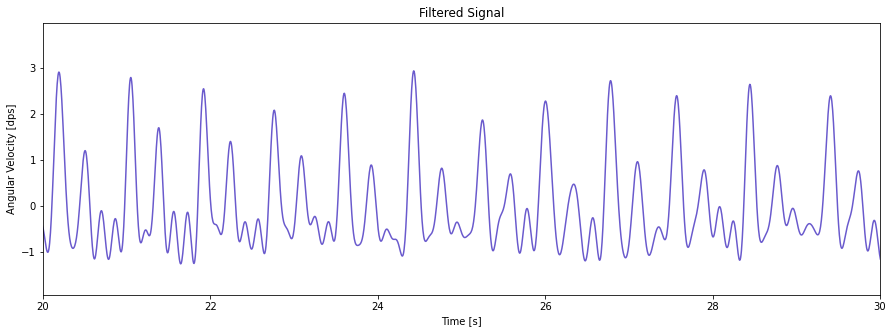

In [22]:
# signal filtered with bandpass filter
f1 = 0.66
f2 = 6

signal_G = FILTER(SIGG_h,f1,f2)

plt.figure(figsize=(15,5))
plt.plot(t, signal_G , 'slateblue')
plt.xlim(20, 30)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')
plt.title('Filtered Signal')

## Accelerometer

[array([-48.19910232, -50.64128698, -53.568918  , ...,  33.84481637,
         28.65665884,  26.76732361]),
 array([ 0.87321017, 10.59347197, -5.64517818, ..., -2.63979464,
        11.00271787,  3.04106098]),
 array([ -6.10647191, -14.38376338,   4.39018084, ...,   5.45172959,
         16.6350196 , -12.09900675]),
 array([  6.19049863, -14.48932045,  10.60148997, ...,   2.3822568 ,
          5.0931188 ,   1.54921934])]

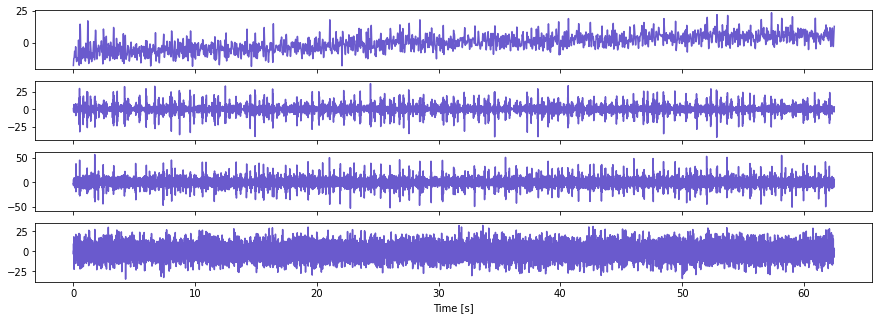

In [23]:
CA = wavelet_decomposition(t, sigA, 3, 'slateblue')
CA

Text(0.5, 1.0, 'Wavelet Filtered Signal')

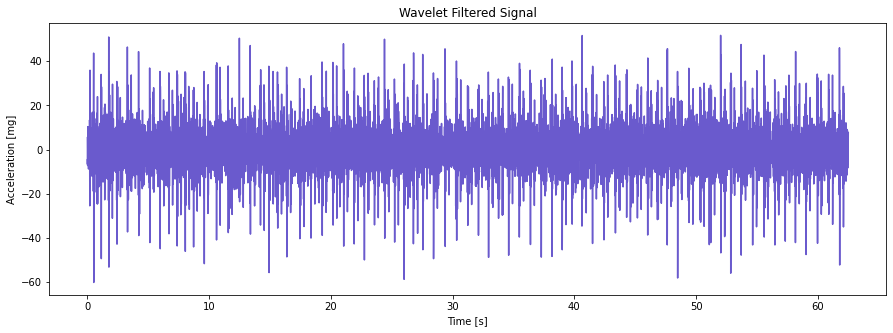

In [24]:
# filtered signal after wavelet decomposition
ca = CA.copy()
for j in range(n+1):
    if (j!=1) & (j!=2): 
        ca[j] = np.zeros_like(ca[j])
sigA_w = pywt.waverec(ca, 'bior5.5')
SIGA = sigA_w[:-1]

plt.figure(figsize=(15,5))
plt.plot(t, SIGA, color = 'slateblue')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [mg]')
plt.title('Wavelet Filtered Signal')

Text(0.5, 0, 'Time [s]')

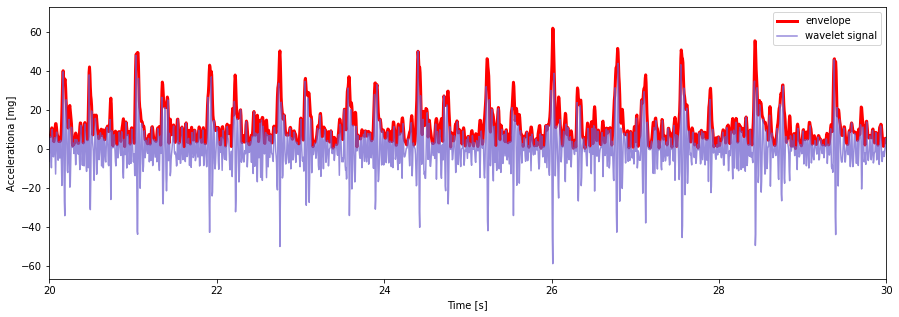

In [25]:
# envelope
SIGA_h = np.abs(signal.hilbert(SIGA))

plt.figure(figsize=(15,5))
plt.plot(t, SIGA_h, color = 'r', linewidth=3, label='envelope')
plt.plot(t, SIGA, 'slateblue', alpha=0.7, label='wavelet signal')
plt.legend(loc='best')
plt.xlim(20, 30)
plt.ylabel('Accelerationa [mg]')
plt.xlabel('Time [s]')

Text(0.5, 1.0, 'Filtered Signal')

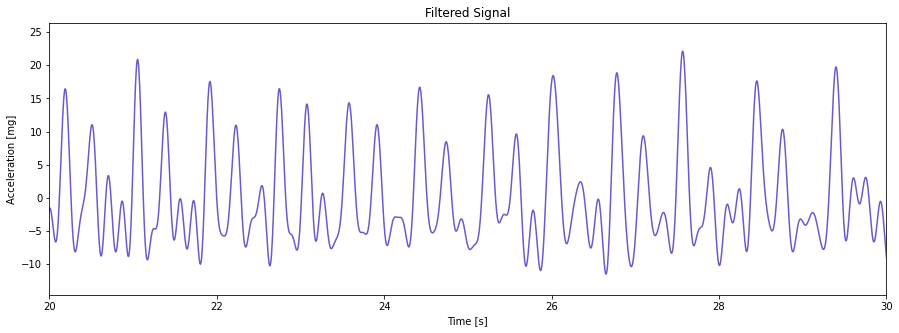

In [26]:
# signal filtered with bandpass filter
f1 = 0.66
f2 = 6

signal_A = FILTER(SIGA_h,f1,f2)

plt.figure(figsize=(15,5))
plt.plot(t, signal_A , 'slateblue')
plt.xlim(20, 30)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')
plt.title('Filtered Signal')

## Find peaks

In [37]:
# function to plot HRV and BPM histo
def histo_func(bins1,peaks1,t):
    peaks_time1=t[peaks1]
    period1 = peaks_time1[1:]-peaks_time1[:-1]
    rate1 = 1/period1*60

    fig = plt.figure(figsize=(12,6))
    gs = GridSpec(3,3)

    ax_main = fig.add_subplot(gs[:,:2])
    ax_marg = fig.add_subplot(gs[:,2])
    ax_main.plot((peaks_time1[1:]+peaks_time1[:-1])*0.5,rate1,marker='o')
    ax_main.set_xlabel('Time (s)')
    ax_main.set_ylabel('Heart BPM')
    ax_main.set_title('Heart BPM as a function of time and histogram')
    l=ax_main.get_ylim()
    h1,b1,_=ax_marg.hist(x=rate1, bins=bins1,orientation='horizontal')
    bin_center1=(b1[1:]+b1[:-1])*0.5
    ax_marg.set_ylim(l)

Text(0.5, 1.0, 'Peaks Detection')

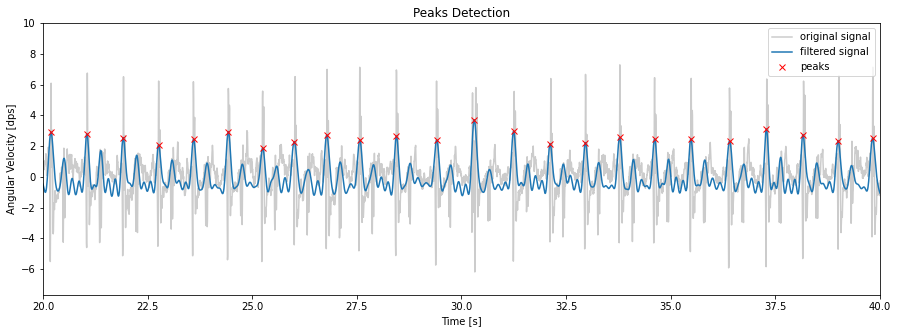

In [38]:
# gyroscope peaks
plt.figure(figsize=(15,5))
plt.plot(t,sigG, color='grey',alpha=0.4,label='original signal')
plt.plot(t,signal_G,label='filtered signal')
peaksG,_ = signal.find_peaks(signal_G, height=0.3 , distance=100)
plt.plot(t[peaksG],signal_G[peaksG], 'rx', label='peaks')
plt.xlim(20,40)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')
plt.legend(loc='upper right')
plt.title('Peaks Detection')

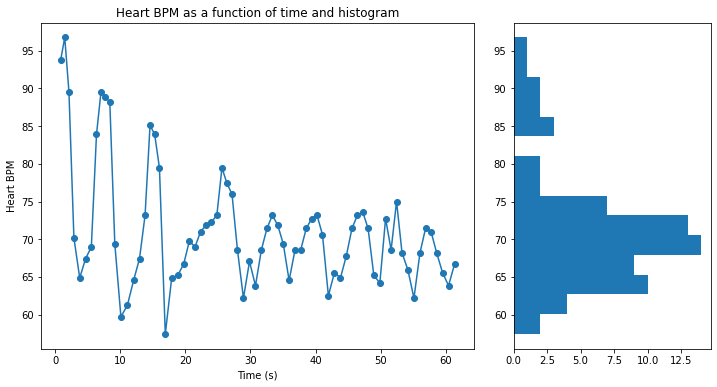

In [39]:
# HRV and BPM histo
histo_func(15,peaksG,t.values)

Text(0.5, 1.0, 'Peaks Detection')

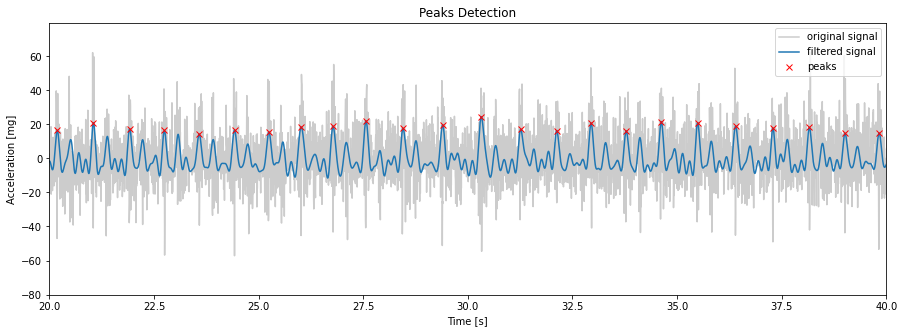

In [40]:
# accelerometer peaks
plt.figure(figsize=(15,5))
plt.plot(t,sigA, color='grey',alpha=0.4,label='original signal')
plt.plot(t,signal_A,label='filtered signal')
peaksA,_ = signal.find_peaks(signal_A, height=0 , distance=125)
plt.plot(t[peaksA],signal_A[peaksA], 'rx', label='peaks')
plt.xlim(20,40)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')
plt.legend(loc='upper right')
plt.title('Peaks Detection')

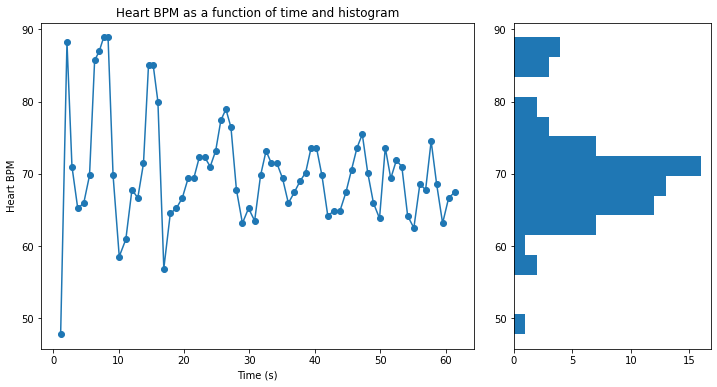

In [41]:
# HRV and BPM histo
histo_func(15,peaksA,t.values)

In [42]:
# function to fix peaks
def fix2(time,peaks,data,thr,r=0.5):
    
    peaks_time=time[peaks]
    period = peaks_time[1:]-peaks_time[:-1]
    #rate = 1/period*60
    
    peaks_new=peaks.copy()
    diff_mean=np.mean(np.abs(period[1:]-period[:-1]))
    for i in np.arange(1,len(period)-1):
        
        peaks_time=time[peaks_new]
        period = peaks_time[1:]-peaks_time[:-1]    
        to_check=np.abs(period[i]-period[i+1])
        
        if to_check>2*(diff_mean):
            if thr==None: new_thr=-m.inf
            else:  new_thr=0.33*(thr+data[peaks_new[i+1]])
                
            if period[i]-period[i+1]>0:
                array=data[(time<time[peaks_new[i+1]]) & (time>time[peaks_new[i+1]]-r)]
                der = array[1:]-array[:-1]
                change=[]
                for d in range(len(der)-1):
                    if der[d]>0 and der[d+1]<0 and array[d+1]>new_thr: change=np.append(change,d+1)
                if len(change)>0:
                    peaks_new[i+1]= peaks_new[i+1]-len(array)+change[-1]
                    peaks_time=time[peaks_new]
                    period = peaks_time[1:]-peaks_time[:-1]
                if np.abs(period[i]-period[i+1])>to_check:
                    peaks_new[i+1]= peaks[i+1]                    
                
            if period[i]-period[i+1]<0: #
                array=data[(time>time[peaks_new[i+1]]) & (time<time[peaks_new[i+1]]+r)]
                der = array[1:]-array[:-1]
                change=np.array([])
                for d in range(len(der)-1):
                    if der[d]>0 and der[d+1]<0 and array[d+1]>new_thr: change=np.append(change,d+1)
                if len(change)>0:
                    peaks_new[i+1]= peaks_new[i+1] + change[0] +1
                    peaks_time=time[peaks_new]
                    period = peaks_time[1:]-peaks_time[:-1]
                if np.abs(period[i]-period[i+1])>to_check:
                    peaks_new[i+1]= peaks[i+1] 
                
    plt.figure(figsize=(10,4))
    plt.plot(time,data)
    plt.plot(time,sigA,color='grey',alpha=0.5)
    plt.plot(time[peaks],data[peaks], 'rx', label='old peaks')
    plt.plot(time[peaks_new],data[peaks_new], 'gx', label='new peaks')
    plt.legend()
    return peaks_new

In [45]:
#se da correggere
#peaks_new_A=to_fix_peaks(t.values,peaksA,signal_A,thr=-5,r=0.3)


In [46]:
#histo_func(10,peaksA,t.values)
#histo_func(10,peaks_new_A,t.values)


## peaks errors and KDE

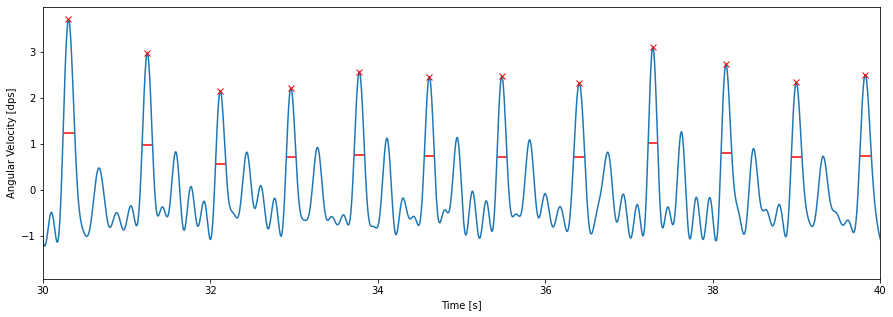

In [59]:
# gyroscope
widths = signal.peak_widths(signal_G, peaksG, rel_height=0.5)

plt.figure(figsize=(15,5))
plt.plot(t.values,signal_G)
plt.plot(t.values[peaksG], signal_G[peaksG],'rx')
plt.hlines(widths[1],xmin=0.005*widths[2],xmax=0.005*widths[3],color='red')
plt.xlim(30,40)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')
plt.show()

Text(0.5, 0, 'BPM')

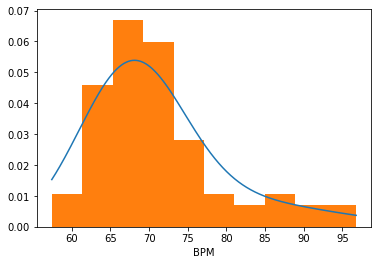

In [60]:
# KDE gyroscope
#uncertainties as unc

const = 2*(2*np.log(2))**0.5
sigma = widths[0]/const*0.01

#peaks_time=np.array([unc.ufloat(t.values[peaksG][i],sigma[i]) for i in range(len(peaksG))])
peaks_time=np.array(t.values[peaksG])

period = peaks_time[1:] - peaks_time[:-1]
sigma_period = (sigma[1:]**2 + sigma[:-1]**2)**0.5
rate = 1/period*60
err_rate = rate/period*sigma_period
#rate_val=np.array([rate[i].n for i in range(len(rate))])
#rate_err=np.array([rate[i].s for i in range(len(rate))])

#KDE gyroscopio
xx = np.linspace(min(rate),max(rate),1000)
fx = np.zeros(xx.shape)
for r,s in zip(rate,err_rate*1.06*err_rate.size**(-1/5)):
    fx += norm.pdf(xx,r,s)

fx = fx/trapz(fx,xx)
plt.plot(xx, fx, label='KDE')
plt.hist(rate, bins=10, density=True)
plt.xlabel('BPM')

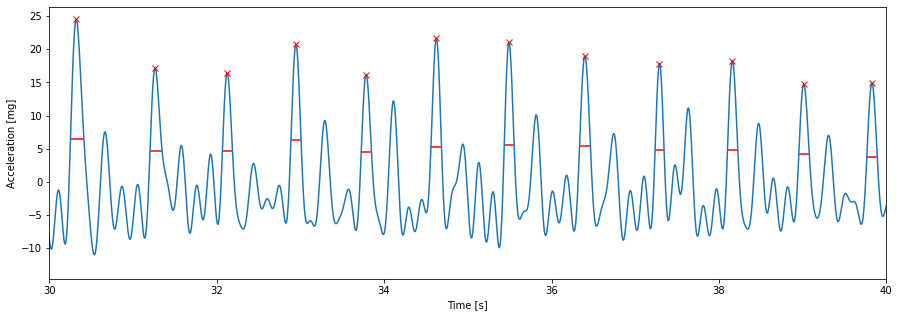

In [58]:
# accelerometer
widths = signal.peak_widths(signal_A, peaksA, rel_height=0.5)

plt.figure(figsize=(15,5))
plt.plot(t.values,signal_A)
plt.plot(t.values[peaksA], signal_A[peaksA],'rx')
plt.hlines(widths[1],xmin=0.005*widths[2],xmax=0.005*widths[3],color='red')
plt.xlim(30,40)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')
plt.show()

Text(0.5, 0, 'BPM')

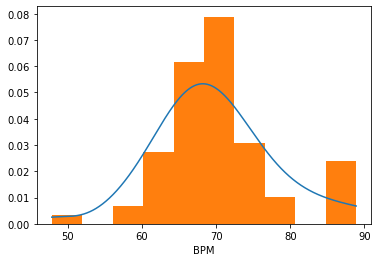

In [52]:
# KDE accelerometer
#import uncertainties as unc

const = 2*(2*np.log(2))**0.5
sigma = widths[0]/const*0.01

#peaks_time=np.array([unc.ufloat(t.values[peaksG][i],sigma[i]) for i in range(len(peaksG))])
peaks_time = np.array(t.values[peaksA])

period = peaks_time[1:] - peaks_time[:-1]
sigma_period = (sigma[1:]**2 + sigma[:-1]**2)**0.5
rate = 1/period*60
err_rate = rate/period*sigma_period
#rate_val=np.array([rate[i].n for i in range(len(rate))])
#rate_err=np.array([rate[i].s for i in range(len(rate))])

#KDE accelerometro
xx = np.linspace(min(rate),max(rate),1000)
fx = np.zeros(xx.shape)
for r,s in zip(rate,err_rate*1.06*err_rate.size**(-1/5)):
    fx += norm.pdf(xx,r,s)

fx = fx/trapz(fx,xx)
plt.plot(xx, fx, label='KDE')
plt.hist(rate, bins=10, density=True)
plt.xlabel('BPM')